In [1]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.3 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-dsrqqn8e
  Entered build tracker: /tmp/pip-build-tracker-dsrqqn8e
  Created temporary directory: /tmp/pip-install-dlucdb2w
  Created temporary directory: /tmp/pip-ephem-wheel-cache-lst5e_34
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  Starting new HTTPS connection (1

In [2]:
!nvidia-smi

Sat Aug  3 21:42:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [4]:
from huggingface_hub import hf_hub_download
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
from llama_cpp import Llama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")

lcpp_llm = None
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


In [6]:
lcpp_llm.params.n_gpu_layers

32

In [7]:
csv = pd.read_csv("/content/drive/MyDrive/TensorGoProject/penguins.csv")

In [8]:
import pandas as pd

def generate_prompt(question, csv_path):
    df = pd.read_csv(csv_path)

    columns = ', '.join(df.columns)
    summary = df.describe().to_string()

    template = f'''
SYSTEM: You are an AI Assistant specialized in data analysis and visualization. Always answer as helpfully and concisely as possible.
Your tasks are to:
1. Analyze CSV data.
2. Answer queries about the data, if it requires calculation perform it and show your results.
3. Generate graphs based on user requests.

CSV File Information:
Columns: {columns}

Data Summary:
{summary}

USER: {question}

ASSISTANT:
'''

    return template


Chatbot initialized. Ready to answer questions about the CSV data. Type 'exit', 'quit', or 'q' to end the conversation.
Ask a question about your CSV data: line plot
Enter the column for x-axis: flipper_length_mm
Enter the column for y-axis: body_mass_g


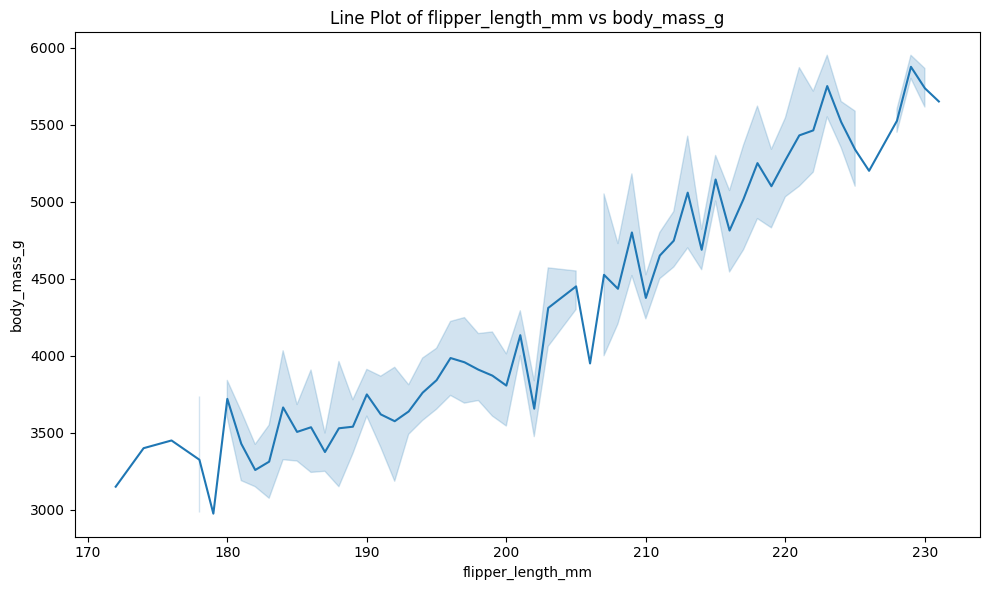

Plot generated successfully. 

Ask a question about your CSV data: pie chart
Enter the column for the pie chart: bill_length_mm


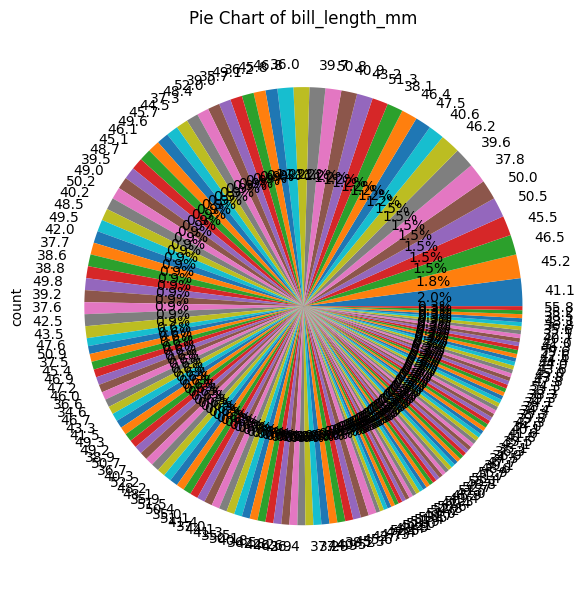

Plot generated successfully. 

Ask a question about your CSV data: pie chart
Enter the column for the pie chart: sex


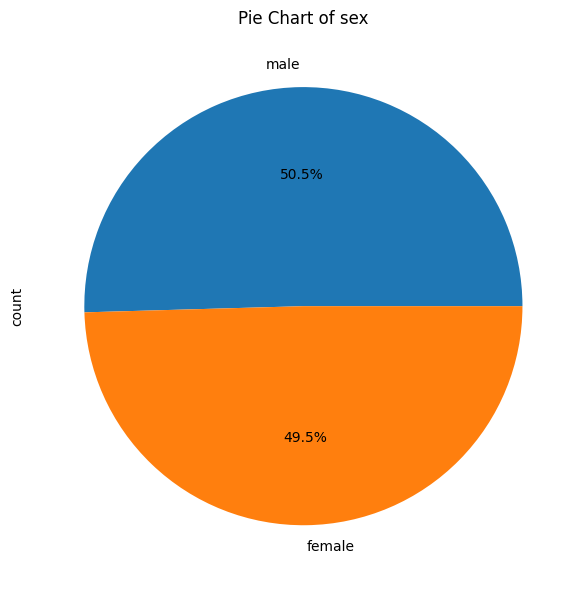

Plot generated successfully. 

Ask a question about your CSV data: bar plot
Enter the column for x-axis: islanda
Enter the column for y-axis: sex
An error occurred while generating the plot: 'islanda' 

Ask a question about your CSV data: bar plot
Enter the column for x-axis: bill_length_mm
Enter the column for y-axis: bill_depth_mm


<Figure size 1000x600 with 0 Axes>

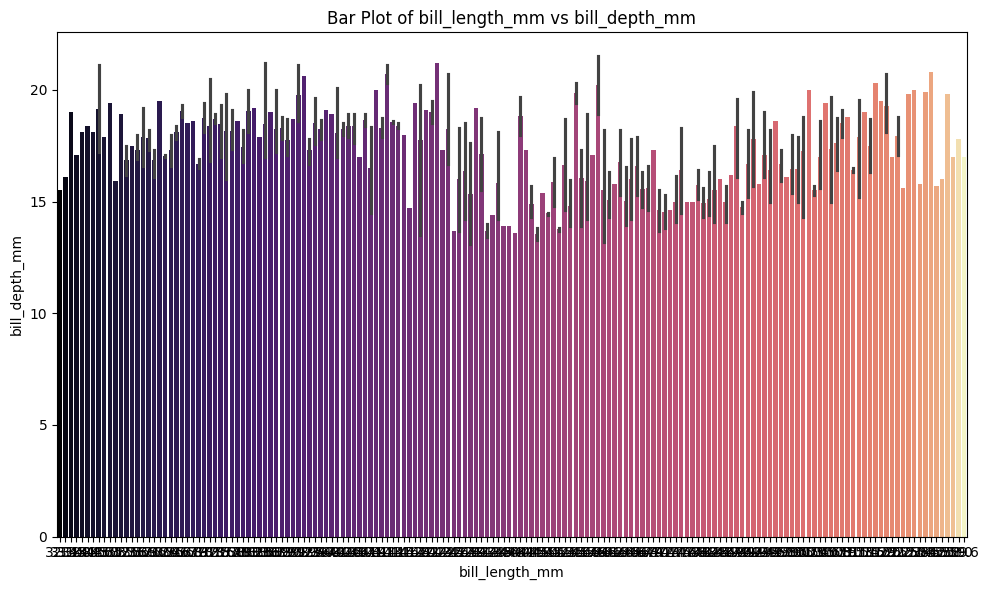

Plot generated successfully. 

Ask a question about your CSV data: exit
Exiting...


In [10]:
def generate_answer(question, csv):
    try:
        prompt_text = generate_prompt(question)

        response = lcpp_llm(prompt=prompt_text, max_tokens=1028, temperature=0.5, top_p=0.95, repeat_penalty=1.2, top_k=150, echo=False)
        return response['choices'][0]['text'].strip()
    except Exception as e:
        return f"An error occurred: {e}"

def plot_graph(plot_type, csv, x_col=None, y_col=None):
    try:
        plt.figure(figsize=(10, 6))
        if plot_type == 'scatter':
            sns.scatterplot(x=csv[x_col], y=csv[y_col], data=csv)
            plt.title(f'Scatter Plot of {x_col} vs {y_col}')
        elif plot_type == 'bar':
            sns.barplot(x=csv[x_col], y=csv[y_col], hue=csv[x_col], data=csv, palette='magma', legend=False)
            plt.title(f'Bar Plot of {x_col} vs {y_col}')
        elif plot_type == 'line':
            sns.lineplot(x=csv[x_col], y=csv[y_col], data=csv)
            plt.title(f'Line Plot of {x_col} vs {y_col}')
        elif plot_type == 'pie':
            csv[x_col].value_counts().plot(kind='pie', autopct='%1.1f%%')
            plt.title(f'Pie Chart of {x_col}')
        elif plot_type == 'histogram':
            plt.hist(csv[x_col], bins=20)
            plt.xlabel(x_col)
            plt.ylabel('Frequency')
            plt.title(f'Histogram of {x_col}')
        else:
            return "Unsupported plot type. Please choose from scatter, bar, line, pie, or histogram."

        plt.tight_layout()
        plt.show()
        return "Plot generated successfully."
    except Exception as e:
        return f"An error occurred while generating the plot: {e}"

def main():
    print("Chatbot initialized. Ready to answer questions about the CSV data. Type 'exit', 'quit', or 'q' to end the conversation.")
    csv = pd.read_csv("/content/drive/MyDrive/TensorGoProject/penguins.csv")
    while True:
        question = input("Ask a question about your CSV data: ").strip()
        if not question:
            continue
        if question.lower() in ['exit', 'quit', 'q']:
            print("Exiting...")
            break

        if "scatter plot" in question.lower():
            x_col = input("Enter the column for x-axis: ").strip()
            y_col = input("Enter the column for y-axis: ").strip()
            result = plot_graph('scatter', csv, x_col, y_col)
        elif "bar plot" in question.lower():
            x_col = input("Enter the column for x-axis: ").strip()
            y_col = input("Enter the column for y-axis: ").strip()
            result = plot_graph('bar', csv, x_col, y_col)
        elif "line plot" in question.lower():
            x_col = input("Enter the column for x-axis: ").strip()
            y_col = input("Enter the column for y-axis: ").strip()
            result = plot_graph('line', csv, x_col, y_col)
        elif "pie chart" in question.lower():
            x_col = input("Enter the column for the pie chart: ").strip()
            result = plot_graph('pie', csv, x_col=x_col)
        elif "histogram" in question.lower():
            x_col = input("Enter the column for the histogram: ").strip()
            result = plot_graph('histogram', csv, x_col=x_col)
        else:
            result = generate_answer(question, csv)

        print(result, '\n')

if __name__ == "__main__":
    main()